# Imports

In [3]:
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numpy import logical_and as land
from scipy.stats import entropy

from utilities import plot_boxplot, get_path

In [4]:
DATA_PATH = get_path()

In [3]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_clean.csv', sep='#')

In [24]:
df_users = pd.read_csv(DATA_PATH+'users_clean.csv', sep='#')

# How many tweets were published by the user?

In [5]:
df_indicators = pd.DataFrame({'n_tweets' : df_tweets.groupby(['user_id'] ).size()}).reset_index()

In [6]:
df_indicators

,user_id,n_tweets
0,000vk,1
1,0013tom,1
2,001gi,1
3,001rx,1
4,00201f,1
...,...,...
140538,zzyb,1
140539,zzyd6,1
140540,zzyyu,1
140541,zzz9v,1


# How many tweets are published by the user in a given period of time?

In [7]:
for y in range(2012, 2021):
  df_indicators[str(y) + "_tweets"] = 0

df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      140543 non-null  object
 1   n_tweets     140543 non-null  int64 
 2   2012_tweets  140543 non-null  int64 
 3   2013_tweets  140543 non-null  int64 
 4   2014_tweets  140543 non-null  int64 
 5   2015_tweets  140543 non-null  int64 
 6   2016_tweets  140543 non-null  int64 
 7   2017_tweets  140543 non-null  int64 
 8   2018_tweets  140543 non-null  int64 
 9   2019_tweets  140543 non-null  int64 
 10  2020_tweets  140543 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 11.8+ MB


In [8]:
for y in range(2012,2021):
  # Filter all tweets published in a certain year
  tweets_by_y = df_tweets[land(df_tweets['publication_date'] >= (str(y)+"-01-01"),
                               df_tweets['publication_date'] <= (str(y)+"-12-31"))][['user_id','publication_date']]

  # Count tweets of users in that year
  gby = pd.DataFrame({'n_tweets' : tweets_by_y.groupby( [ 'user_id'] ).size()}).reset_index()

  # Transform it in a dictionary
  gby = dict(zip(gby.user_id, gby.n_tweets))

  # Select users to modify and update them in df_indicators
  df_indicators.loc[df_indicators['user_id'].isin(gby.keys()), str(y)+'_tweets'] = list(gby.values())

<BarContainer object of 9 artists>

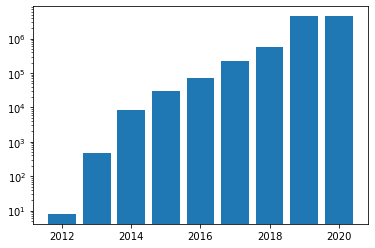

In [9]:
# Number of tweets per year
years_col_list = [str(y)+'_tweets' for y in range(2012,2021)]
sum_list = [df_indicators[y].sum() for y in years_col_list]
plt.bar(range(2012,2021), sum_list, log=True)

# Total number of tweets

In [10]:
tot_n_tweets = df_tweets.shape[0]
tot_n_tweets

9816550

# Total number of likes and comments and retweets

In [11]:
total_favorite = df_tweets.favorite_count.sum()
total_favorite

18713553

In [12]:
total_replies = df_tweets.reply_count.sum()
total_replies

10756391

In [13]:
total_retweets = df_tweets.retweet_count.sum()
total_retweets

1826047102

# Ratio between the number of tweets and the number of likes

In [14]:
ratio_tweets_fav = len(df_tweets) / total_favorite
ratio_tweets_fav

0.5245690115607656

## Ratio between the number of tweets and the number of retweets

In [15]:
ratio_tweets_rt = len(df_tweets) / total_retweets
ratio_tweets_rt

0.005375847090279493

## Ratio between the number of tweets and the number of comments

In [16]:
ratio_tweets_replies = len(df_tweets) / total_replies
ratio_tweets_replies

0.9126248757599087

# Average length of the tweets per user

In [17]:
# For each tweet save its length
df_tweets['length'] = df_tweets.text.astype(str).apply(len)

<AxesSubplot:>

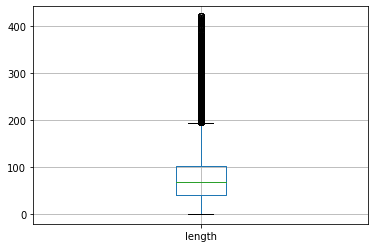

In [18]:
df_tweets.boxplot('length')

In [19]:
# For each user compute the mean of the length of each of their tweets
len_groupby = df_tweets.groupby('user_id').agg({'length':'mean'})

In [20]:
df_indicators['mean_length'] = len_groupby.length.values
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      140543 non-null  object 
 1   n_tweets     140543 non-null  int64  
 2   2012_tweets  140543 non-null  int64  
 3   2013_tweets  140543 non-null  int64  
 4   2014_tweets  140543 non-null  int64  
 5   2015_tweets  140543 non-null  int64  
 6   2016_tweets  140543 non-null  int64  
 7   2017_tweets  140543 non-null  int64  
 8   2018_tweets  140543 non-null  int64  
 9   2019_tweets  140543 non-null  int64  
 10  2020_tweets  140543 non-null  int64  
 11  mean_length  140543 non-null  float64
dtypes: float64(1), int64(10), object(1)
memory usage: 12.9+ MB


In [21]:
df_indicators.max()

user_id         zzza
n_tweets        3324
2012_tweets        7
2013_tweets      169
2014_tweets      885
2015_tweets     1662
2016_tweets     2708
2017_tweets     3114
2018_tweets     3085
2019_tweets     3300
2020_tweets     3270
mean_length    365.0
dtype: object

# Average number of special characters in the tweets per user

In [22]:
# Takes into account all the chars that are not whitespaces or alphanumeric and compute the number for each tweet
df_tweets['special_chars'] = df_tweets.text.astype(str).apply(lambda text: len(re.findall("(?=\W)(?=\S)", text)))

In [23]:
# Compute the mean of the special chars of each tweet by user
len_groupby = df_tweets.groupby('user_id').agg({'special_chars':'mean'})

df_indicators['mean_special_chars'] = len_groupby.special_chars.values
df_indicators

,user_id,n_tweets,2012_tweets,2013_tweets,2014_tweets,2015_tweets,2016_tweets,2017_tweets,2018_tweets,2019_tweets,2020_tweets,mean_length,mean_special_chars
0,000vk,1,0,0,0,0,0,0,0,0,1,110.0,9.0
1,0013tom,1,0,0,0,0,0,0,1,0,0,104.0,5.0
2,001gi,1,0,0,0,0,0,0,0,0,1,15.0,0.0
3,001rx,1,0,0,0,0,0,0,0,0,1,47.0,0.0
4,00201f,1,0,0,0,0,0,0,0,1,0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140538,zzyb,1,0,0,0,0,0,0,0,1,0,3.0,0.0
140539,zzyd6,1,0,0,0,0,0,0,0,1,0,66.0,0.0
140540,zzyyu,1,0,0,0,0,0,0,0,0,1,64.0,1.0
140541,zzz9v,1,0,0,0,0,0,0,0,1,0,3.0,0.0


# File Checkpoint

In [24]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_with_indicators.csv', sep='#', index=False)

In [25]:
df_indicators.to_csv(path_or_buf=DATA_PATH+'indicators_1.csv', sep='#', index=False)

In [5]:
df_indicators = pd.read_csv(DATA_PATH+'indicators_1.csv', sep='#')

In [6]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_with_indicators.csv', sep='#')

# Mean, standard deviation, entropy, total and ratio with the total number of tweets for each attribute by user

In [7]:
user_groupby = df_tweets.groupby('user_id').agg(['mean','std',entropy,'sum'])

C:\Users\al\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
C:\Users\al\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
C:\Users\al\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
C:\Users\al\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
C:\Users\al\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
C:\Users\al\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered 

In [8]:
# Don't take into account length and special chars
user_groupby.drop(columns=['length','special_chars'], inplace=True)

In [9]:
# Convert from multiindex to "{column_name}_mean", "{column_name}_std", "{column_name}_entropy"
cols = list(user_groupby.columns.map('_'.join).str.strip('_'))

In [10]:
df_indicators[cols] = user_groupby.values

In [11]:
# Max value of each attribute
df_indicators.max()

user_id                                                 zzza
n_tweets                                                3324
2012_tweets                                                7
2013_tweets                                              169
2014_tweets                                              885
2015_tweets                                             1662
2016_tweets                                             2708
2017_tweets                                             3114
2018_tweets                                             3085
2019_tweets                                             3300
2020_tweets                                             3270
mean_length                                            365.0
mean_special_chars                                     213.0
publication_date_in_secs_mean          1588500732000000000.0
publication_date_in_secs_std            132553602926447472.0
publication_date_in_secs_entropy                 1196.543239
publication_date_in_secs

Add the ratio columns by dividing the sumns by the total number of tweets for each user.

In [12]:
for attr in df_indicators.columns:
    if '_sum' in attr:
        df_indicators[attr.replace('sum','ratio')] = df_indicators[attr]/df_indicators.n_tweets

In [13]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 48 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   user_id                           140543 non-null  object 
 1   n_tweets                          140543 non-null  int64  
 2   2012_tweets                       140543 non-null  int64  
 3   2013_tweets                       140543 non-null  int64  
 4   2014_tweets                       140543 non-null  int64  
 5   2015_tweets                       140543 non-null  int64  
 6   2016_tweets                       140543 non-null  int64  
 7   2017_tweets                       140543 non-null  int64  
 8   2018_tweets                       140543 non-null  int64  
 9   2019_tweets                       140543 non-null  int64  
 10  2020_tweets                       140543 non-null  int64  
 11  mean_length                       140543 non-null  f

Check if there are null values in the aggregated columns

# Tweeting regularity
We want an indicator that can tell us if the user has a certain regularity in the publication.
We define the tweeting regularity of a user as:
$$ Entropy( \{\ timestamp_i - timestamp_j\ |\ j = i + 1 \} )$$

In [14]:
def tweeting_regularity(user_timestamps):

    user_timestamps = user_timestamps.values

    # If user only has one tweet
    if(len(user_timestamps) == 1):
        return 0

    # Sort items by date and compute differences between a tweet and its successor
    user_timestamps.sort()
    diffs = []
    for i in range(1,len(user_timestamps)):
        diffs.append(user_timestamps[i]-user_timestamps[i-1])
    diffs = np.array(diffs)

    return entropy(diffs)

df_indicators['tweeting_regularity'] = df_tweets.groupby('user_id').agg({'publication_date_in_secs': tweeting_regularity}).values

C:\Users\al\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [15]:
df_indicators['tweeting_regularity'].value_counts()

0.000000    128979
4.364155         1
3.462674         1
5.806535         1
5.641228         1
             ...  
2.628242         1
2.437555         1
2.496194         1
2.410906         1
0.678564         1
Name: tweeting_regularity, Length: 11562, dtype: int64

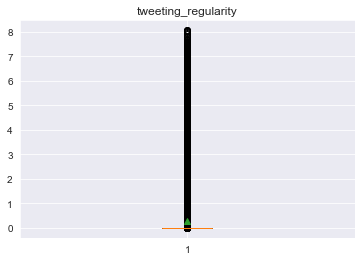

In [16]:
plot_boxplot(df_indicators[df_indicators.tweeting_regularity.notnull()],'tweeting_regularity')

# Maximum number of tweets in a day by user

Add new column which represents the date as the number of the day in the year (e.g. 1st of Janueary would be 1, 2nd of January would be 2, [...], 31st of December would be 365 or 366) concatenated to the year.
For example, 2nd of January of 2019 would be "2_2019".

In [17]:
df_tweets['day_of_year'] = pd.DatetimeIndex(df_tweets.publication_date).day_of_year.map(str) + "_" + pd.DatetimeIndex(df_tweets.publication_date).year.map(str)

In [18]:
df_tweets['day_of_year']

0          254_2019
1           92_2020
2          122_2019
3          308_2019
4           71_2020
             ...   
9816545     96_2019
9816546     27_2019
9816547    116_2019
9816548    108_2020
9816549    191_2019
Name: day_of_year, Length: 9816550, dtype: object

In [19]:
# Group tweets by user and count for each day of each year how much they posted that day
user_date_groupby = pd.DataFrame({'n_tweets_by_day' : df_tweets.groupby( [ 'user_id', 'day_of_year'] ).size()}).reset_index()

In [20]:
user_date_groupby

,user_id,day_of_year,n_tweets_by_day
0,000vk,118_2020,1
1,0013tom,99_2018,1
2,001gi,98_2020,1
3,001rx,70_2020,1
4,00201f,43_2019,1
...,...,...,...
1151381,zzyb,306_2019,1
1151382,zzyd6,170_2019,1
1151383,zzyyu,88_2020,1
1151384,zzz9v,106_2019,1


In [21]:
# Maximum number of tweets in a day
user_date_groupby[user_date_groupby['n_tweets_by_day'] == user_date_groupby['n_tweets_by_day'].max()]

,user_id,day_of_year,n_tweets_by_day
778142,492649414,115_2020,3238


Identify maximum number of tweets posted in a day for each user.

In [22]:
df_indicators['max_daily_tweets'] = user_date_groupby.groupby(by=['user_id']).agg({'n_tweets_by_day':max}).values

# Density of publication and other attributes

In [25]:
secs_in_min = 60
mins_in_hour = 60
hours_in_day = 24
secs_per_day = secs_in_min * mins_in_hour * hours_in_day

gropuby_userid = df_tweets.groupby('user_id')

# Compute date of the last tweet posted by the user
df_indicators['last_tweet_dates'] = gropuby_userid.agg({'publication_date_in_secs':'max'}).values

# Compute date of first tweet posted by the user
df_indicators['first_tweet_dates'] = gropuby_userid.agg({'publication_date_in_secs':'min'}).values

df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='right')

def attribute_density(attr_total):
    """
    Compute the density for a given attribute as (total_amount)/user_activity_period.
    user_activity_period is defined as the time span from the user subscription to its latest tweet.
    :param attr_total:  the column name that contains the sum for the attribute. In this notebook it was computed along with mean, std and entropy.
    :return:
    """

    def get_user_density(row):

        # If we know the date of user subscription
        if not pd.isnull(row.user_subscription_in_secs):
            # uses the user's Twitter subscription
            density = row[attr_total]/((row.last_tweet_dates-row.user_subscription_in_secs)/secs_per_day)
        else:
            try:
                # otherwise uses the date of the user's first tweet
                density = row[attr_total]/((row.last_tweet_dates-row.first_tweet_dates)/secs_per_day)
            except ZeroDivisionError:
                # An error can occur when a user has no match in df_users and has only one published tweet
                density = -1

        return density


    attr_density = df_merge.apply(get_user_density, axis=1)
    # Replaces -1 values with the maximum of the density of the attribute + the std of the attribute
    attr_density.replace(-1, attr_density.max()+attr_density.std(), inplace=True)

    return attr_density

In [26]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         11508 non-null  object 
 1   name                       11507 non-null  object 
 2   lang                       11508 non-null  object 
 3   bot                        11508 non-null  int64  
 4   user_subscription          11508 non-null  object 
 5   statuses_count             11508 non-null  float64
 6   user_subscription_in_secs  11508 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 629.5+ KB


In [28]:
# Computes density for all attributes
for attr in ['retweet_count_sum', 'reply_count_sum', 'favorite_count_sum', 'num_mentions_sum', 'num_hashtags_sum', 'num_urls_sum']:
  df_indicators[f'{attr}'.replace('sum','density')] = attribute_density(attr)

df_indicators['n_tweets_density'] = attribute_density('n_tweets')

In [30]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 56 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   user_id                           140543 non-null  object 
 1   n_tweets                          140543 non-null  int64  
 2   2012_tweets                       140543 non-null  int64  
 3   2013_tweets                       140543 non-null  int64  
 4   2014_tweets                       140543 non-null  int64  
 5   2015_tweets                       140543 non-null  int64  
 6   2016_tweets                       140543 non-null  int64  
 7   2017_tweets                       140543 non-null  int64  
 8   2018_tweets                       140543 non-null  int64  
 9   2019_tweets                       140543 non-null  int64  
 10  2020_tweets                       140543 non-null  int64  
 11  mean_length                       140543 non-null  f

# Drop utils columns

Drops columns that were needed to compute the indicators but that won't be useful for further analyses.

In [29]:
df_indicators.drop(columns=['last_tweet_dates','first_tweet_dates','publication_date_in_secs_sum'], inplace=True)

In [33]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 56 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   user_id                           140543 non-null  object 
 1   n_tweets                          140543 non-null  int64  
 2   2012_tweets                       140543 non-null  int64  
 3   2013_tweets                       140543 non-null  int64  
 4   2014_tweets                       140543 non-null  int64  
 5   2015_tweets                       140543 non-null  int64  
 6   2016_tweets                       140543 non-null  int64  
 7   2017_tweets                       140543 non-null  int64  
 8   2018_tweets                       140543 non-null  int64  
 9   2019_tweets                       140543 non-null  int64  
 10  2020_tweets                       140543 non-null  int64  
 11  mean_length                       140543 non-null  f

In [34]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         11508 non-null  object 
 1   name                       11507 non-null  object 
 2   lang                       11508 non-null  object 
 3   bot                        11508 non-null  int64  
 4   user_subscription          11508 non-null  object 
 5   statuses_count             11508 non-null  float64
 6   user_subscription_in_secs  11508 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 629.5+ KB


# File Checkpoint

In [35]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_with_indicators.csv', sep='#', index=False)

In [36]:
df_indicators.to_csv(path_or_buf=DATA_PATH+'indicators.csv', sep='#', index=False)